In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import pandas as pd
import time
from igraph import *
import csv

In [2]:
# Generate Graph , nodes=10, edges=30 and export to csv
G = Graph.Erdos_Renyi(n=100,m=300,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))

b=G.get_edgelist()

with open('b.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    #write.writerow(fields)
    write.writerows(b)

In [2]:
#Read csv as Graph object

df=pd.read_csv("b.csv", header=None)

In [3]:
df

,0,1
0,0,53
1,1,86
2,2,99
3,2,37
4,2,64
...,...,...
295,98,24
296,98,30
297,98,34
298,99,10


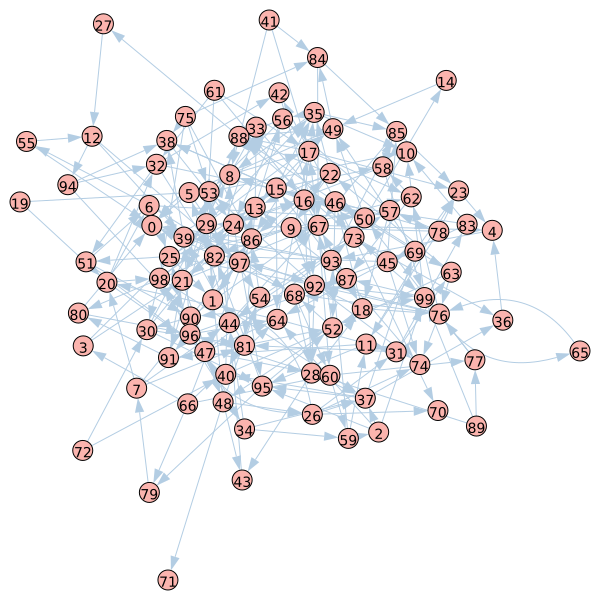

In [4]:
source=df[0]
s=list(source)

target=df[1]
t=target.tolist()

g1 = Graph(directed=True)
g1.add_vertices(range(100))
g1.add_edges(zip(s,t))

# Plot graph
g1.vs["label"], g1.es["color"], g1.vs["color"] = range(100), "#B3CDE3", "#FBB4AE"
#png("my_plot.png", 600, 600)
#dev.off()
plot(g1,bbox = (200,200),margin = 20,layout = g1.layout("kk"),)
plot(g1, "g2.png", dpi=300)

In [5]:
#convert df by adding compatibility factor

df['compf'] = np.random.randint(0,2, size=len(df))

In [6]:
df

,0,1,compf
0,0,53,0
1,1,86,1
2,2,99,0
3,2,37,1
4,2,64,1
...,...,...,...
295,98,24,0
296,98,30,0
297,98,34,1
298,99,10,0


In [7]:
#removing entries where compatibility = 0
df1= df[df['compf'] != 0]

In [8]:
df1

,0,1,compf
1,1,86,1
3,2,37,1
4,2,64,1
5,2,95,1
9,5,0,1
...,...,...,...
284,95,82,1
289,96,91,1
292,97,13,1
293,97,22,1


In [23]:
df1.to_csv('b1.csv')

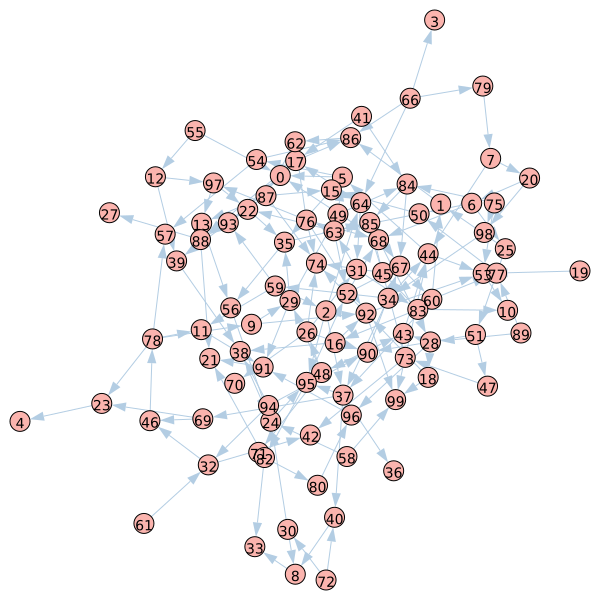

In [25]:
#regenerating graph

source=df1[0]
s=list(source)

target=df1[1]
t=target.tolist()

g2 = Graph(directed=True)
g2.add_vertices(range(100))
g2.add_edges(zip(s,t))

# Plot graph
g2.vs["label"], g2.es["color"], g2.vs["color"] = range(100), "#B3CDE3", "#FBB4AE"

g2.vs.select(_degree=0).delete() #delete nodes with no edges

#png("my_plot.png", 600, 600)
#dev.off()
plot(g2,bbox = (200,200),margin = 20,layout = g2.layout("kk"),)
plot(g2, "g2_modified.png", dpi=300)

In [85]:
#to print all vertices in igraph object

g2vs=[]
for v in g2.vs:
    g2vs.append(v)

TypeError: list indices must be integers or slices, not tuple

In [145]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        if len(A)>94:
            print(A)
        
    return(np.mean(spread))


In [69]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)


In [70]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)


In [138]:
# ***
# Run algorithms with unmodified graph
celf_output1   = celf(g1,10,p = 0.1,mc = 1000)

[0, 53, 1, 10, 86, 62, 58, 87, 99, 67, 74, 13, 15, 24, 64, 33, 35, 4, 38, 16, 17, 81, 56, 60, 95, 37, 39, 8, 73, 77, 79, 18, 82, 20, 52, 85, 23, 88, 59, 28, 93, 31, 2, 6, 7, 11, 14, 21, 27, 32, 36, 40, 42, 43, 44, 46, 47, 48, 50, 63, 68, 69, 76, 80, 83, 92, 96, 98, 65, 34, 97, 5, 12, 45, 78, 49, 51, 55, 22, 54, 25, 26, 91, 29, 30, 70, 9, 84, 57, 90, 94]
[1, 86, 0, 62, 58, 53, 87, 67, 99, 10, 74, 13, 15, 24, 64, 33, 35, 4, 38, 16, 17, 81, 56, 60, 95, 37, 39, 8, 73, 77, 79, 18, 82, 20, 52, 85, 23, 88, 59, 28, 93, 31, 2, 6, 7, 11, 14, 21, 27, 32, 36, 40, 42, 43, 44, 46, 47, 48, 50, 63, 68, 69, 76, 80, 83, 92, 96, 98, 65, 34, 97, 5, 12, 45, 78, 49, 51, 55, 22, 54, 25, 26, 91, 29, 30, 70, 9, 84, 57, 90, 94]
[2, 64, 99, 37, 95, 36, 69, 40, 10, 79, 17, 82, 20, 52, 87, 31, 4, 6, 7, 8, 11, 13, 15, 21, 23, 32, 33, 46, 47, 49, 62, 63, 67, 68, 74, 80, 81, 83, 86, 98, 0, 5, 16, 22, 24, 25, 28, 30, 34, 35, 38, 39, 42, 44, 45, 48, 50, 51, 55, 56, 58, 60, 73, 76, 78, 84, 88, 91, 93, 96, 97, 1, 65, 90,

[25, 1, 51, 13, 33, 6, 47, 81, 20, 86, 56, 90, 0, 24, 26, 28, 30, 32, 39, 48, 50, 52, 53, 55, 62, 64, 67, 68, 73, 88, 98, 4, 8, 10, 12, 14, 15, 16, 17, 18, 21, 27, 29, 31, 34, 36, 37, 38, 42, 43, 44, 46, 49, 54, 58, 60, 63, 69, 70, 74, 82, 87, 92, 95, 96, 5, 11, 22, 23, 35, 40, 57, 59, 76, 77, 78, 79, 80, 83, 84, 91, 93, 94, 97, 99, 65, 2, 7, 9, 45, 85]
[26, 74, 37, 70, 31, 36, 69, 40, 11, 81, 83, 95, 63, 4, 39, 8, 10, 76, 45, 46, 79, 16, 49, 82, 52, 22, 23, 91, 5, 7, 9, 13, 17, 18, 21, 28, 33, 35, 38, 50, 62, 64, 65, 67, 68, 73, 78, 80, 84, 86, 88, 92, 93, 0, 14, 15, 20, 24, 25, 27, 29, 42, 43, 44, 48, 53, 54, 56, 57, 58, 60, 85, 87, 96, 97, 32, 1, 98, 99, 6, 12, 77, 47, 51, 59, 2, 34, 55, 94, 90, 30]
[27, 12, 97, 94, 39, 32, 1, 38, 13, 22, 90, 92, 9, 24, 25, 26, 28, 30, 33, 35, 42, 46, 48, 51, 53, 56, 67, 74, 81, 82, 86, 0, 4, 6, 8, 10, 16, 17, 18, 20, 21, 29, 31, 37, 43, 47, 50, 52, 54, 60, 62, 70, 73, 78, 80, 85, 88, 95, 96, 11, 14, 15, 23, 36, 40, 44, 49, 55, 57, 58, 59, 63, 64, 6

[50, 73, 15, 63, 49, 64, 35, 36, 5, 38, 42, 44, 76, 14, 52, 84, 22, 88, 58, 0, 4, 8, 9, 10, 13, 17, 20, 21, 24, 27, 31, 53, 54, 56, 62, 65, 67, 68, 74, 85, 86, 98, 99, 1, 6, 11, 12, 16, 23, 25, 28, 29, 30, 32, 33, 34, 40, 47, 48, 57, 60, 69, 81, 82, 83, 87, 92, 93, 95, 96, 97, 37, 39, 91, 43, 45, 46, 77, 79, 80, 18, 51, 55, 26, 59, 94, 2, 70, 7, 78, 90]
[51, 90, 20, 6, 47, 32, 64, 98, 67, 68, 73, 48, 50, 55, 25, 26, 28, 30, 0, 1, 4, 8, 12, 13, 14, 15, 17, 18, 24, 29, 31, 34, 36, 37, 42, 43, 44, 46, 49, 54, 60, 63, 69, 70, 74, 81, 82, 95, 96, 5, 11, 16, 21, 22, 23, 33, 35, 38, 39, 40, 52, 53, 56, 57, 58, 59, 62, 76, 77, 78, 79, 80, 83, 84, 86, 87, 88, 91, 92, 93, 94, 97, 65, 2, 99, 7, 9, 10, 45, 85, 27]
[52, 67, 68, 0, 4, 69, 28, 17, 60, 96, 1, 37, 43, 13, 46, 77, 49, 18, 53, 86, 23, 59, 93, 62, 2, 5, 10, 11, 25, 33, 36, 39, 40, 44, 48, 50, 56, 58, 64, 76, 78, 81, 84, 85, 87, 88, 92, 95, 8, 9, 15, 20, 21, 24, 26, 27, 29, 31, 38, 51, 54, 57, 63, 65, 73, 74, 79, 82, 91, 98, 99, 32, 34, 35

[77, 50, 76, 65, 68, 73, 74, 15, 49, 62, 63, 0, 64, 35, 36, 5, 38, 69, 42, 44, 14, 60, 52, 84, 22, 87, 88, 58, 28, 1, 4, 8, 9, 10, 13, 17, 18, 20, 21, 23, 24, 27, 31, 37, 43, 46, 53, 54, 56, 59, 67, 85, 86, 96, 98, 99, 2, 6, 11, 12, 16, 25, 29, 30, 32, 33, 34, 39, 40, 47, 48, 57, 78, 81, 82, 83, 92, 93, 95, 97, 45, 79, 80, 51, 55, 26, 91, 94, 90, 70, 7]
[78, 9, 11, 23, 57, 4, 82, 18, 50, 56, 25, 91, 92, 29, 95, 1, 13, 15, 21, 24, 28, 33, 35, 46, 48, 49, 51, 52, 53, 63, 73, 74, 76, 79, 80, 88, 93, 0, 5, 6, 7, 8, 10, 14, 16, 20, 22, 26, 27, 36, 37, 38, 39, 42, 43, 44, 47, 54, 58, 62, 64, 65, 67, 68, 81, 84, 85, 86, 90, 96, 32, 97, 98, 99, 69, 70, 40, 12, 17, 87, 55, 60, 30, 31, 34, 77, 83, 59, 94, 2, 45]
[79, 7, 81, 20, 44, 97, 32, 1, 98, 67, 5, 6, 39, 13, 47, 52, 53, 22, 0, 4, 9, 10, 15, 17, 24, 25, 28, 30, 33, 34, 35, 38, 42, 46, 48, 50, 51, 54, 55, 56, 60, 64, 68, 73, 82, 86, 92, 8, 12, 14, 16, 18, 21, 23, 26, 29, 31, 36, 37, 40, 43, 49, 57, 58, 59, 62, 63, 69, 74, 77, 78, 80, 85, 88,

[47, 50, 64, 73, 15, 48, 49, 28, 63, 5, 14, 17, 18, 20, 22, 26, 29, 31, 35, 36, 37, 38, 42, 43, 44, 52, 54, 58, 76, 84, 88, 96, 0, 4, 6, 8, 9, 10, 11, 13, 21, 23, 24, 25, 27, 32, 39, 40, 46, 53, 56, 57, 62, 65, 67, 68, 69, 70, 74, 81, 83, 85, 86, 87, 91, 92, 95, 98, 99, 1, 33, 34, 12, 45, 78, 79, 16, 80, 82, 51, 55, 60, 93, 30, 97, 7, 77, 90, 59, 94, 2]
[47, 16, 64, 35, 8, 73, 48, 18, 28, 10, 14, 17, 20, 26, 29, 31, 33, 36, 37, 42, 43, 44, 46, 54, 56, 76, 85, 92, 96, 4, 5, 6, 11, 13, 23, 24, 25, 32, 39, 40, 49, 50, 52, 53, 57, 62, 63, 65, 67, 68, 69, 70, 74, 78, 81, 83, 86, 87, 88, 91, 95, 98, 0, 1, 9, 15, 21, 22, 27, 30, 34, 38, 45, 51, 55, 58, 60, 79, 80, 82, 84, 93, 99, 7, 12, 77, 90, 59, 97, 2, 94]
[47, 76, 64, 65, 68, 73, 74, 48, 28, 62, 0, 14, 17, 18, 20, 26, 29, 31, 36, 37, 42, 43, 44, 54, 58, 60, 69, 87, 96, 1, 4, 5, 6, 11, 13, 15, 23, 24, 25, 32, 35, 39, 40, 46, 49, 53, 57, 59, 63, 67, 70, 77, 81, 83, 86, 88, 91, 92, 95, 98, 99, 2, 8, 10, 16, 21, 22, 27, 30, 33, 34, 38, 45, 50

[47, 87, 64, 67, 73, 74, 13, 15, 48, 28, 4, 14, 17, 18, 20, 26, 29, 31, 33, 35, 36, 37, 38, 42, 43, 44, 54, 56, 58, 60, 81, 96, 1, 5, 6, 8, 10, 11, 23, 24, 25, 32, 39, 40, 46, 49, 52, 53, 57, 59, 62, 63, 69, 70, 76, 77, 83, 85, 86, 88, 91, 92, 93, 95, 98, 99, 0, 2, 16, 21, 22, 27, 30, 34, 45, 50, 51, 55, 65, 68, 78, 79, 80, 82, 84, 9, 90, 12, 7, 97, 94]
[47, 62, 64, 73, 48, 87, 58, 28, 13, 14, 15, 17, 18, 20, 24, 26, 29, 31, 36, 37, 42, 43, 44, 54, 67, 74, 96, 99, 4, 5, 6, 10, 11, 16, 23, 25, 32, 33, 35, 38, 39, 40, 46, 49, 53, 56, 57, 60, 63, 69, 70, 76, 81, 83, 86, 88, 91, 92, 95, 98, 0, 1, 8, 21, 22, 27, 30, 34, 45, 50, 51, 52, 55, 59, 65, 68, 77, 78, 79, 80, 82, 84, 85, 93, 2, 7, 9, 12, 90, 97, 94]
[47, 91, 64, 73, 48, 80, 21, 28, 0, 96, 67, 36, 37, 42, 43, 44, 13, 14, 17, 18, 20, 54, 26, 29, 31, 4, 5, 6, 11, 23, 25, 32, 33, 35, 39, 40, 46, 49, 53, 56, 57, 60, 62, 63, 69, 70, 74, 76, 81, 83, 86, 87, 88, 92, 95, 98, 1, 8, 10, 15, 16, 22, 24, 27, 30, 34, 38, 45, 50, 51, 52, 55, 58, 5

[47, 9, 64, 73, 28, 48, 82, 25, 92, 29, 1, 13, 14, 17, 18, 20, 21, 26, 31, 33, 35, 36, 37, 42, 43, 44, 49, 51, 53, 54, 74, 80, 88, 91, 96, 0, 4, 5, 6, 8, 10, 11, 23, 27, 32, 39, 40, 46, 56, 57, 62, 63, 67, 69, 70, 76, 81, 83, 84, 85, 86, 87, 90, 95, 98, 12, 15, 16, 22, 24, 30, 34, 38, 45, 50, 52, 55, 58, 60, 65, 68, 78, 79, 93, 97, 99, 7, 77, 59, 94, 2]
[47, 34, 64, 37, 73, 44, 48, 59, 28, 2, 5, 11, 14, 17, 18, 20, 26, 29, 31, 36, 40, 42, 43, 53, 54, 67, 69, 93, 95, 96, 98, 0, 1, 4, 6, 8, 10, 13, 15, 23, 24, 25, 30, 32, 35, 39, 46, 49, 52, 57, 60, 62, 63, 70, 74, 76, 79, 81, 82, 83, 85, 86, 87, 88, 91, 92, 99, 7, 16, 21, 22, 27, 33, 38, 45, 50, 51, 55, 56, 58, 65, 68, 77, 78, 80, 84, 9, 90, 12, 97, 94]
[47, 60, 64, 1, 37, 73, 77, 48, 59, 28, 2, 11, 14, 17, 18, 20, 26, 29, 31, 36, 40, 42, 43, 44, 50, 54, 69, 76, 86, 93, 95, 96, 0, 4, 5, 6, 8, 13, 15, 23, 25, 32, 35, 39, 46, 49, 52, 53, 57, 62, 63, 65, 67, 68, 70, 74, 79, 81, 82, 83, 85, 87, 88, 91, 92, 98, 99, 7, 10, 16, 21, 22, 24, 27,

[47, 52, 64, 67, 68, 73, 48, 28, 0, 96, 4, 36, 37, 69, 42, 43, 44, 14, 17, 18, 20, 54, 26, 60, 29, 31, 1, 5, 6, 11, 13, 23, 25, 32, 35, 39, 40, 46, 49, 53, 57, 59, 62, 63, 70, 74, 76, 77, 81, 83, 86, 87, 88, 91, 92, 93, 95, 98, 2, 8, 10, 15, 16, 21, 22, 24, 27, 30, 33, 34, 38, 45, 50, 51, 55, 56, 58, 65, 78, 79, 80, 82, 84, 85, 99, 7, 9, 12, 90, 97, 94]
[47, 95, 64, 73, 79, 48, 82, 52, 28, 7, 14, 17, 18, 20, 21, 26, 29, 31, 33, 36, 37, 42, 43, 44, 54, 67, 68, 80, 96, 0, 4, 5, 6, 11, 13, 23, 25, 32, 35, 39, 40, 46, 49, 53, 57, 60, 62, 63, 69, 70, 74, 76, 81, 83, 86, 87, 88, 91, 92, 97, 98, 1, 8, 10, 15, 16, 22, 24, 27, 30, 34, 38, 45, 50, 51, 55, 56, 58, 59, 65, 77, 78, 84, 85, 93, 2, 99, 9, 12, 90, 94]
[47, 88, 64, 73, 48, 21, 27, 28, 96, 67, 36, 37, 42, 43, 44, 13, 14, 12, 17, 18, 20, 54, 26, 29, 31, 4, 5, 6, 11, 23, 25, 32, 33, 35, 39, 40, 46, 49, 53, 56, 57, 60, 62, 63, 69, 70, 74, 76, 81, 83, 86, 87, 91, 92, 94, 95, 97, 98, 0, 1, 8, 10, 15, 16, 22, 24, 30, 34, 38, 45, 50, 51, 52, 5

[47, 76, 2, 64, 65, 99, 68, 37, 73, 74, 48, 28, 62, 95, 0, 10, 14, 17, 18, 20, 26, 29, 31, 36, 40, 42, 43, 44, 52, 54, 58, 60, 69, 79, 82, 87, 96, 1, 4, 5, 6, 7, 8, 11, 13, 15, 21, 23, 24, 25, 32, 33, 35, 39, 46, 49, 53, 57, 59, 63, 67, 70, 77, 80, 81, 83, 86, 88, 91, 92, 98, 97, 34, 38, 45, 78, 16, 50, 51, 84, 85, 22, 55, 56, 27, 93, 30, 9, 90, 12, 94]
[47, 76, 2, 90, 64, 65, 99, 68, 37, 67, 73, 74, 48, 62, 26, 28, 30, 95, 0, 4, 8, 10, 14, 17, 18, 20, 24, 29, 31, 36, 40, 42, 43, 44, 52, 54, 58, 60, 69, 70, 79, 81, 82, 87, 96, 1, 5, 6, 7, 11, 13, 15, 16, 21, 23, 25, 32, 33, 35, 39, 46, 49, 53, 57, 59, 63, 77, 80, 83, 86, 88, 91, 92, 93, 98, 97, 34, 38, 45, 78, 50, 51, 84, 85, 22, 55, 56, 27, 9, 12, 94]
[47, 76, 2, 78, 64, 65, 99, 68, 37, 73, 74, 9, 11, 48, 23, 57, 28, 62, 95, 0, 4, 10, 14, 17, 18, 20, 25, 26, 29, 31, 36, 40, 42, 43, 44, 50, 52, 54, 56, 58, 60, 69, 79, 82, 87, 91, 92, 96, 1, 5, 6, 7, 8, 13, 15, 21, 24, 32, 33, 35, 39, 46, 49, 51, 53, 59, 63, 67, 70, 77, 80, 81, 83, 86, 

[47, 76, 2, 90, 22, 69, 9, 13, 23, 26, 28, 30, 35, 37, 46, 48, 49, 62, 64, 65, 67, 68, 73, 74, 86, 95, 99, 0, 4, 5, 8, 10, 14, 17, 18, 20, 24, 25, 29, 31, 33, 36, 40, 42, 43, 44, 50, 52, 54, 56, 58, 60, 70, 78, 79, 81, 82, 84, 85, 87, 88, 92, 96, 1, 6, 7, 11, 15, 16, 21, 27, 32, 39, 51, 53, 57, 59, 63, 77, 80, 83, 91, 93, 98, 97, 34, 38, 12, 45, 55, 94]
[47, 76, 2, 90, 22, 97, 1, 9, 13, 26, 28, 30, 35, 37, 48, 62, 64, 65, 67, 68, 73, 74, 86, 95, 99, 0, 4, 8, 10, 14, 17, 18, 20, 24, 25, 29, 31, 33, 36, 40, 42, 43, 44, 52, 54, 56, 58, 60, 69, 70, 79, 81, 82, 85, 87, 92, 96, 5, 6, 7, 11, 15, 16, 21, 23, 32, 39, 46, 49, 51, 53, 57, 59, 63, 77, 80, 83, 88, 91, 93, 98, 34, 38, 45, 78, 50, 84, 55, 27, 12, 94]
[47, 76, 2, 90, 22, 4, 9, 13, 26, 28, 30, 35, 37, 48, 62, 64, 65, 67, 68, 73, 74, 86, 93, 95, 99, 0, 8, 10, 14, 17, 18, 20, 24, 25, 29, 31, 33, 36, 39, 40, 42, 43, 44, 52, 54, 56, 58, 60, 69, 70, 79, 81, 82, 85, 87, 92, 96, 1, 5, 6, 7, 11, 15, 16, 21, 23, 32, 38, 46, 49, 51, 53, 57, 59, 

[47, 76, 2, 90, 22, 51, 6, 9, 13, 20, 26, 28, 30, 35, 37, 48, 62, 64, 65, 67, 68, 73, 74, 86, 95, 99, 0, 4, 8, 10, 14, 17, 18, 24, 25, 29, 31, 32, 33, 36, 40, 42, 43, 44, 50, 52, 54, 55, 56, 58, 60, 69, 70, 79, 81, 82, 85, 87, 92, 96, 98, 1, 5, 7, 11, 12, 15, 16, 21, 23, 34, 39, 46, 49, 53, 57, 59, 63, 77, 80, 83, 88, 91, 93, 97, 38, 45, 78, 84, 27, 94]
[47, 76, 2, 90, 22, 79, 7, 9, 13, 26, 28, 30, 35, 37, 48, 62, 64, 65, 67, 68, 73, 74, 86, 95, 99, 0, 4, 8, 10, 14, 17, 18, 20, 24, 25, 29, 31, 33, 36, 40, 42, 43, 44, 52, 54, 56, 58, 60, 69, 70, 81, 82, 85, 87, 92, 96, 97, 1, 5, 6, 11, 15, 16, 21, 23, 32, 39, 46, 49, 51, 53, 57, 59, 63, 77, 80, 83, 88, 91, 93, 98, 34, 38, 45, 78, 50, 84, 55, 27, 12, 94]
[47, 76, 2, 90, 22, 0, 9, 13, 26, 28, 30, 35, 37, 48, 53, 62, 64, 65, 67, 68, 73, 74, 86, 95, 99, 1, 4, 8, 10, 14, 17, 18, 20, 24, 25, 29, 31, 33, 36, 40, 42, 43, 44, 52, 54, 56, 58, 60, 69, 70, 79, 81, 82, 85, 87, 92, 96, 5, 6, 7, 11, 15, 16, 21, 23, 32, 39, 46, 49, 51, 57, 59, 63, 77, 

[47, 76, 2, 90, 22, 78, 45, 83, 9, 10, 11, 13, 16, 23, 26, 28, 30, 35, 37, 48, 57, 62, 64, 65, 67, 68, 73, 74, 82, 86, 95, 99, 0, 4, 8, 14, 17, 18, 20, 21, 24, 25, 29, 31, 33, 36, 40, 42, 43, 44, 50, 52, 54, 56, 58, 60, 69, 70, 79, 80, 81, 85, 87, 91, 92, 96, 32, 1, 98, 5, 6, 7, 39, 77, 46, 15, 49, 51, 53, 88, 59, 93, 63, 97, 34, 38, 84, 55, 27, 12, 94]
[47, 76, 2, 90, 22, 78, 45, 66, 3, 9, 11, 13, 23, 26, 28, 30, 35, 37, 48, 57, 60, 62, 64, 65, 67, 68, 73, 74, 79, 82, 86, 95, 99, 0, 1, 4, 7, 8, 10, 14, 17, 18, 20, 21, 24, 25, 29, 31, 33, 36, 40, 42, 43, 44, 50, 52, 54, 56, 58, 59, 69, 70, 77, 80, 81, 85, 87, 91, 92, 96, 32, 97, 98, 5, 6, 39, 46, 15, 16, 49, 51, 83, 53, 88, 93, 63, 34, 38, 84, 55, 27, 12, 94]
[47, 76, 2, 90, 22, 78, 45, 66, 12, 3, 9, 11, 13, 23, 26, 28, 30, 35, 37, 39, 48, 57, 60, 62, 64, 65, 67, 68, 73, 74, 79, 82, 86, 94, 95, 97, 99, 0, 1, 4, 7, 8, 10, 14, 17, 18, 20, 21, 24, 25, 29, 31, 32, 33, 36, 38, 40, 42, 43, 44, 50, 52, 54, 56, 58, 59, 69, 70, 77, 80, 81, 85, 

In [159]:
# ***
touch1=[47, 76, 2, 90, 22, 78, 45, 66, 12, 16, 3, 8, 9, 11, 13, 18, 23, 26, 28, 30, 35, 37, 39, 48, 57, 60, 62, 64, 65, 67, 68, 73, 74, 79, 82, 86, 94, 95, 97, 99, 0, 1, 4, 7, 10, 14, 17, 20, 21, 24, 25, 29, 31, 32, 33, 36, 38, 40, 42, 43, 44, 46, 50, 52, 54, 56, 58, 59, 69, 70, 77, 80, 81, 85, 87, 91, 92, 96, 98, 5, 6, 15, 49, 51, 83, 53, 88, 93, 63, 34, 27, 84, 55]

In [160]:
# ***
len(touch1)

93

In [161]:
# ***
lg1=[1,0,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,]

In [162]:
# ***
def common_member(a, b):
    result = [i for i in a if i in b]
    return result



In [163]:
# ***
a=common_member(touch1,lg1)


In [164]:
# ***
len(a)

90

In [ ]:
greedy_output1 = greedy(g1,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output1[0]))
print("greedy output: " + str(greedy_output1[0]))

In [84]:
celf_output1

([47, 76, 2, 90, 22, 78, 45, 66, 12, 16],
 [5.999, 8.358, 10.595, 12.655, 14.601, 16.17, 17.703, 19.129, 20.547, 21.923],
 [13.513441801071167,
  41.06355595588684,
  43.38808822631836,
  46.344470739364624,
  49.00192308425903,
  67.9250819683075,
  72.7880527973175,
  80.74025058746338,
  82.76420450210571,
  86.43382596969604],
 [100, 90, 7, 7, 6, 37, 8, 12, 3, 5])

In [85]:
greedy_output1

([47, 76, 2, 90, 22, 78, 45, 66, 12, 16],
 [5.999, 8.358, 10.595, 12.655, 14.601, 16.17, 17.703, 19.129, 20.547, 21.923],
 [13.574585914611816,
  38.085503816604614,
  70.82575988769531,
  109.42852878570557,
  155.79290652275085,
  205.34636974334717,
  256.8882038593292,
  310.22897696495056,
  367.1246359348297,
  428.66758275032043])

In [146]:
# ***
# Run algorithms
celf_output2   = celf(g2,10,p = 1.0,mc = 1000)

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 20, 22, 26, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 81, 82, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 0, 96, 3, 37, 39, 75, 12, 77, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 16, 49, 17, 61, 94, 92, 93, 30, 13, 14, 19, 21, 25, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 85, 88, 89, 1, 5, 6, 9, 11, 15, 2

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 0, 96, 3, 37, 39, 75, 12, 77, 16, 81, 63, 83, 52, 87, 23, 27, 29, 31, 65, 38, 7, 8, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 32, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69, 79, 80, 84, 88, 89, 1, 34, 66, 4, 5, 6, 36, 68, 72, 74, 44, 78, 15, 48, 55, 90, 95, 33, 67, 35, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 31, 0, 3, 12, 16, 23, 27, 29, 37, 39, 41, 45, 52, 63, 75, 77, 81, 83, 87, 96, 65, 38, 7, 8, 10, 42, 76, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 9, 11, 13, 14, 19, 20, 21, 22, 25, 26, 28, 32, 43, 51, 56, 59, 62, 69

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 5, 6, 9, 11, 15, 22, 34, 36, 44, 48, 55, 56, 66, 68, 72, 74, 78, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 29, 0, 96, 3, 37, 39, 8, 75, 12, 77, 16, 81, 83, 52, 87, 23, 27, 63, 31, 32, 65, 38, 7, 41, 10, 42, 45, 47, 17, 49, 82, 93, 85, 94, 92, 61, 30, 13, 14, 19, 20, 21, 25, 26, 28, 43, 51, 59, 62, 69, 76, 79, 80, 84, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 66, 36, 5, 6, 68, 72, 9, 74, 11, 44, 78, 15, 48, 22, 56, 90, 95, 33, 35, 4, 67, 71, 53, 24, 50, 58, 2, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 12, 0, 3, 16, 23, 27, 29, 31, 37, 38, 39, 52, 63, 75, 77, 81, 83, 87, 94, 96, 65, 7, 8, 41, 10, 42, 13, 45, 47, 17, 49, 82, 93, 21, 85, 92, 61, 30, 14, 19, 20, 25, 26, 28, 32, 34, 43, 51, 55, 59, 62, 69, 76, 79, 8

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]
[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 5

In [151]:
# ***
touch2=[64, 70, 60, 54, 91, 18, 86, 57, 40, 73, 0, 3, 12, 16, 23, 27, 29, 31, 37, 39, 52, 63, 75, 77, 81, 83, 87, 95, 96, 7, 8, 10, 17, 30, 33, 38, 41, 42, 45, 47, 49, 61, 65, 82, 85, 92, 93, 94, 13, 14, 19, 20, 21, 25, 26, 28, 32, 36, 43, 51, 58, 59, 62, 69, 76, 79, 80, 84, 88, 89, 1, 2, 5, 6, 9, 11, 15, 22, 34, 35, 44, 48, 55, 56, 66, 67, 68, 72, 74, 78, 90, 24, 4, 53, 71, 50, 46]

In [152]:
# ***
b=common_member(touch2,lg1)
len(b)

94

In [ ]:
greedy_output2 = greedy(g2,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output2[0]))
print("greedy output: " + str(greedy_output2[0]))


In [87]:
celf_output2

([66, 75, 12, 50, 6, 26, 34, 89, 76, 61],
 [2.915, 4.778, 6.545, 8.28, 9.84, 11.329, 12.716, 14.026, 15.33, 16.626],
 [6.046263694763184,
  12.724778890609741,
  14.540562152862549,
  15.898226499557495,
  19.63041353225708,
  23.780867099761963,
  30.893401861190796,
  35.212398529052734,
  36.5612530708313,
  37.546436071395874],
 [100, 47, 9, 5, 13, 12, 18, 10, 3, 2])

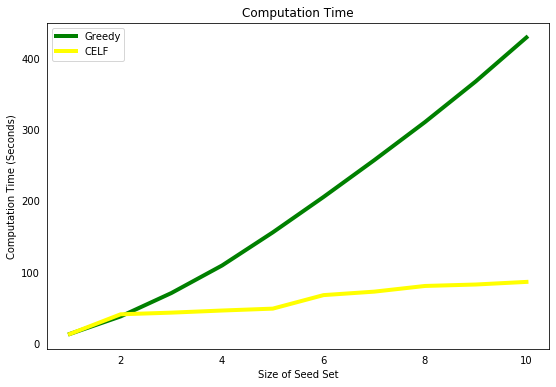

In [88]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output1[2])+1),greedy_output1[2],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[2])+1),celf_output1[2],label="CELF",color="yellow")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);


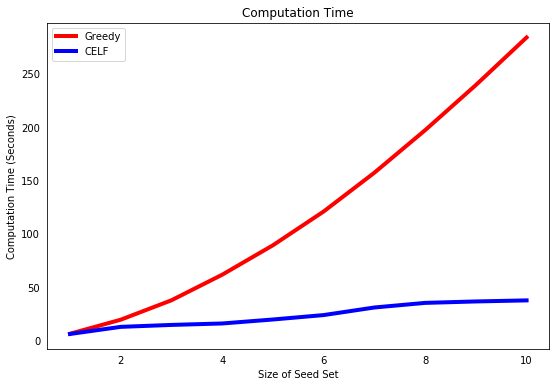

In [89]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output2[2])+1),greedy_output2[2],label="Greedy",color="red")
plt.plot(range(1,len(celf_output2[2])+1),celf_output2[2],label="CELF",color="blue")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

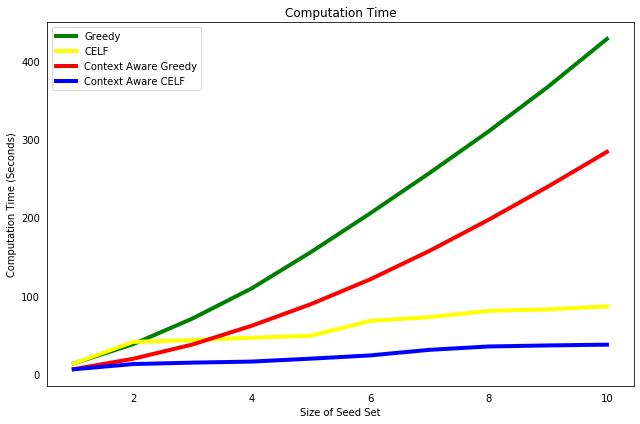

In [90]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output1[2])+1),greedy_output1[2],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[2])+1),celf_output1[2],label="CELF",color="yellow")
plt.plot(range(1,len(greedy_output2[2])+1),greedy_output2[2],label="Context Aware Greedy",color="red")
plt.plot(range(1,len(celf_output2[2])+1),celf_output2[2],label="Context Aware CELF",color="blue")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);
plt.tight_layout()
plt.savefig("g2i.jpg", dpi=300)

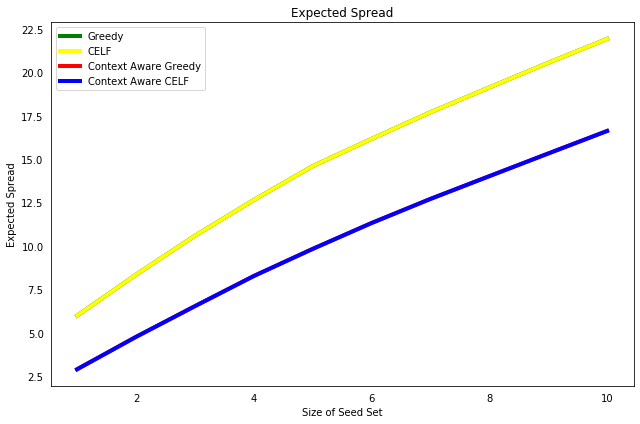

In [91]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output1[1])+1),greedy_output1[1],label="Greedy",color="green")
plt.plot(range(1,len(celf_output1[1])+1),celf_output1[1],label="CELF",color="yellow")
plt.plot(range(1,len(greedy_output2[1])+1),greedy_output2[1],label="Context Aware Greedy",color="red")
plt.plot(range(1,len(celf_output2[1])+1),celf_output2[1],label="Context Aware CELF",color="blue")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);
plt.tight_layout()
plt.savefig("g2ii.jpg", dpi=300)